In [1]:
import sys
import matplotlib.pyplot as plt
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import initialize_database
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest
from backtest.visualize.backtest_visualize import cum_return_plot, position_change_plot, position_change_average_plot


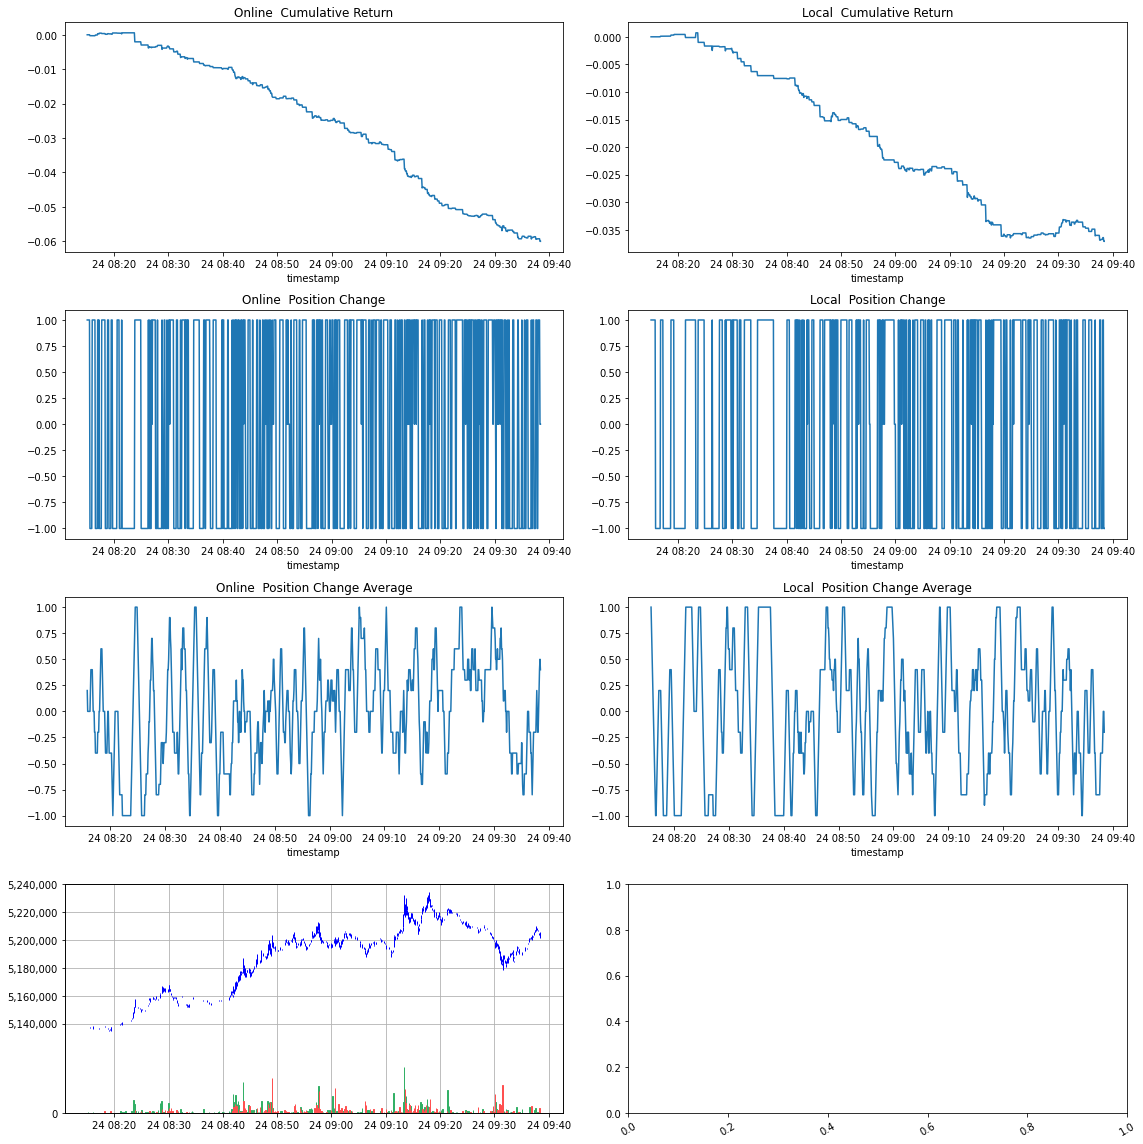

In [2]:
symbol = "BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

# fig, axes = plt.subplots(2, 1, figsize=(16, 8))
# axes = axes.flatten()

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)
result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 1000
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df, buy_df=local_timestamped_buy_df, sell_df=local_timestamped_sell_df)

_, ax = plt.subplots(4, 2, figsize=(16, 16))
ax = ax.flatten()
cum_return_plot(ax[0], result_online["cumulative_return"], 'Online')
cum_return_plot(ax[1], result_local["cumulative_return"], 'Local')
position_change_plot(ax[2], result_online["position"], 'Online')
position_change_plot(ax[3], result_local["position"], 'Local')
position_change_average_plot(ax[4], result_online["position"], 'Online')
position_change_average_plot(ax[5], result_local["position"], 'Local')
ohlcv_plot(ax[6], ohlcv_df)
plt.tight_layout()
plt.show()


In [3]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-24 09:36:00+00:00,5193407.0,5194532.0,-1125.0
2022-03-24 09:36:05+00:00,5194117.0,5194532.0,-415.0
2022-03-24 09:36:10+00:00,5194961.0,5194532.0,429.0
2022-03-24 09:36:15+00:00,5195599.0,5198170.0,-2571.0
2022-03-24 09:36:20+00:00,5197021.0,5198170.0,-1149.0
2022-03-24 09:36:25+00:00,5197474.0,5200277.0,-2803.0
2022-03-24 09:36:30+00:00,5198033.0,5200277.0,-2244.0
2022-03-24 09:36:35+00:00,5200390.0,5200277.0,113.0
2022-03-24 09:36:40+00:00,5200534.0,5200592.0,-58.0


In [4]:
ohlcv_df.tail(40)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-03-24 09:35:10+00:00,5193107.0,5193107.0,5193107.0,5193801.0,0.02,5193301.0
2022-03-24 09:35:15+00:00,5193801.0,5193805.0,5193801.0,5193801.0,0.04,5193301.0
2022-03-24 09:35:20+00:00,5193801.0,5193801.0,5193801.0,5193801.0,0.00,5193301.0
2022-03-24 09:35:25+00:00,5193801.0,5193801.0,5193801.0,5193801.0,0.00,5193301.0
2022-03-24 09:35:30+00:00,5193801.0,5193801.0,5193801.0,5193801.0,0.00,5193301.0
2022-03-24 09:35:35+00:00,5193063.0,5194025.0,5193063.0,5194903.0,0.08,5194403.0
2022-03-24 09:35:40+00:00,5194903.0,5194903.0,5191892.0,5194903.0,0.08,5194403.0
2022-03-24 09:35:45+00:00,5194903.0,5194903.0,5194903.0,5194903.0,0.00,5194403.0
2022-03-24 09:35:50+00:00,5195189.0,5195189.0,5195189.0,5193899.0,0.04,5193399.0


In [5]:
timestamped_buy_df.head(30)

,side,price,size,predict_value,symbol,acutual_timestamp
timestamp,,,,,,
2022-03-24 08:15:05+00:00,BUY,5137955.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:05.054000+00:00
2022-03-24 08:15:10+00:00,BUY,5137918.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:10.035000+00:00
2022-03-24 08:15:15+00:00,BUY,5137093.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:15.036000+00:00
2022-03-24 08:15:20+00:00,BUY,5137076.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:20.037000+00:00
2022-03-24 08:15:25+00:00,BUY,5136903.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:25.036000+00:00
2022-03-24 08:15:30+00:00,BUY,5136998.0,0.01,0.999972,BTC_JPY,2022-03-24 08:15:30.353000+00:00
2022-03-24 08:15:35+00:00,BUY,5135976.0,0.01,1.000011,BTC_JPY,2022-03-24 08:15:35.237000+00:00
2022-03-24 08:15:40+00:00,BUY,5135998.0,0.01,1.000016,BTC_JPY,2022-03-24 08:15:40.233000+00:00
2022-03-24 08:15:45+00:00,BUY,5136674.0,0.01,1.000000,BTC_JPY,2022-03-24 08:15:45.038000+00:00
